<a href="https://colab.research.google.com/github/Momegaii/pytorch_O_core/blob/main/pytorch_O_core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1: Tensors & Basic Operations

In [ ]:
from re import X
import torch
import matplotlib.pyplot as plt

a = torch.tensor([1,2,3])

b = torch.tensor([[4,5,6],[1,1,1]])

# matrix multiplaction
mm = torch.matmul(b,a)
print(mm.shape)
a.shape
b.shape

line = torch.tensor([1,2,3,4,1,2,3,4,1,2])
line2 = torch.tensor([30,40,50,60,70,30,40,50,60,70])
print(line)




class Data():
  def __init__(self)  :
    self.x = torch.tensor([1,2,3,4,4.5,4.2,4.5,4.4,5,1,2,3,4,1,2])
    self.y = torch.tensor([10,20,30,40,45,42,45,44,50,10,20,30,40,10,20])
    self.x_yr = self.y *0.1 +self.x


  def check_shape(self):
    print(self.x.shape)
    print(self.y.shape)
  def vol_arr(self):
    vol = torch.randn(15,)
    return vol
  def v(self):
    vol = self.vol_arr()
    plt.plot(self.x_yr)
    plt.hist(vol)
    plt.show()
  def dv(self):
    print(self.x.device)
  def move_cuda(self):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.x = self.x.to(device)
    self.y = self.y.to(device)
    self.x_yr = self.x_yr.to(device)
    print("x: ->",self.x.device,"/","y: ->",self.y.device,"/","xyrelate : -> ",self.x_yr.device)

  def matrix_M(self):


      print("-"*70)
      print("error you need an array and its not none to turn into tensors ")



data = Data()

torch.Size([2])
tensor([1, 2, 3, 4, 1, 2, 3, 4, 1, 2])


In [ ]:
data.matrix_M()

----------------------------------------------------------------------
error you need an array and its not none to turn into tensors 


# lesson 2 : Autograd & Backpropagation

Example 1 — Scalar functions, finite-difference check, higher-order derivatives, create_graph and retain_graph

In [ ]:
import torch

torch.manual_seed(0)

x = torch.tensor(2.0,requires_grad=True)
y = x**3 + 2 * x**2 +3 *x+5

y.backward(retain_graph=True)
print("autograd dy/dx x.grad : ", x.grad.item())

eps = 1e-6
x_val = x.detach().item()
fd = ( (x_val + eps)**3 + 2*(x_val + eps)**2 + 3*(x_val + eps) + 5
     - ((x_val - eps)**3 + 2*(x_val - eps)**2 + 3*(x_val - eps) + 5) ) / (2*eps)
print("finite  ; -> ",fd)

x.grad.zero_()
g = torch.autograd.grad(y,x,create_graph=True)[0]
d2 = torch.autograd.grad(g,x)[0]
print("d2 : ",d2.item())



autograd dy/dx x.grad :  23.0
finite  ; ->  23.000000000550358
d2 :  16.0


In [ ]:
# 12. Alternatively, using backward with retain_graph to compute twice from y (not recommended routinely)
x.grad.zero_()
y.backward(retain_graph=True)      # allows another backward on the same graph
first = x.grad.item()
x.grad.zero_()
# compute a new upstream scalar (for pedagogy) and backward again
y.backward()
second = x.grad.item()
print("first via backward:", first, "second via backward:", second)


first via backward: 23.0 second via backward: 23.0


Example 2 — Vector outputs, Jacobians, VJP (vector–Jacobian product) and explicit Jacobian construction

In [ ]:
import torch

torch.manual_seed(0)


x = torch.randn(3,requires_grad=True)

y = torch.stack([x[0]*x[1]+torch.sin(x[2]),x[1]**2 + torch.exp(x[0])])

from torch.autograd.functional import jacobian


J = jacobian(lambda t: torch.stack([t[0]*t[1] + torch.sin(t[2]),
                                   t[1]**2 + torch.exp(t[0])]), x)

print("J (2x3):\n",J)

J_manual = []
for i in range(y.shape[0]):
    # retain_graph because we need to compute gradient for each output
    grad_i = torch.autograd.grad(y[i], x, retain_graph=True)[0]
    J_manual.append(grad_i)
J_manual = torch.stack(J_manual)  # shape [2,3]
print(" ")
print(" ")
print("i stepes: ",i)

print(" ")
print("J_manual:\n", J_manual)

J (2x3):
 tensor([[-0.2934,  1.5410, -0.5712],
        [ 4.6692, -0.5869,  0.0000]])
 
 
i stepes:  1
 
J_manual:
 tensor([[-0.2934,  1.5410, -0.5712],
        [ 4.6692, -0.5869,  0.0000]])


the above are not good for nn.modules ingeneral (advanced ones) but the next example : ex3 is the best for the **utilities** that we need in @O% changing lines

Example 3 — Small MLP: forward, manual backward derivation, compare with autograd, and Hessian-vector product via create_graph

In [ ]:
import torch
torch.manual_seed(0)

# 1. small dataset (batch_size=4, input_dim=2)
X = torch.randn(4, 2)
y_true = torch.randn(4, 1)   # regression targets

# 2. model params — use raw tensors (not nn.Linear) so formulas are clear
in_dim, hid_dim, out_dim = 2, 3, 1
W1 = torch.randn(hid_dim, in_dim, requires_grad=True)  # weight matrix of layer1 (out, in)
b1 = torch.zeros(hid_dim, requires_grad=True)          # bias1 (hid,)
W2 = torch.randn(out_dim, hid_dim, requires_grad=True) # weight matrix of layer2 (out, hid)
b2 = torch.zeros(out_dim, requires_grad=True)          # bias2 (out,)

# 3. forward (vectorized over batch)
z1 = X @ W1.T + b1           # shape (4, 3)  ; X (4,2) @ W1.T (2,3) -> (4,3)
a1 = torch.relu(z1)          # element-wise ReLU, shape (4,3)
z2 = a1 @ W2.T + b2          # shape (4,1)
y_pred = z2                  # final predictions

# 4. MSE loss
N = X.shape[0]
loss = ((y_pred - y_true)**2).mean()   # scalar

# 5. autograd compute gradients
loss.backward()              # populates W1.grad, b1.grad, W2.grad, b2.grad

# 6. stash autograd grads for comparison
autograd_grads = {
    'dW2': W2.grad.clone(),
    'db2': b2.grad.clone(),
    'dW1': W1.grad.clone(),
    'db1': b1.grad.clone()
}

# 7. manual gradients via matrix calculus (no autograd; use .detach() to avoid tracking)
with torch.no_grad():
    # detach everything used to compute hand-derived quantities
    Xd = X.detach()
    yd = y_true.detach()
    z1d = z1.detach()
    a1d = a1.detach()
    W2d = W2.detach()

# 8. derivative of loss wrt y_pred: dL/dy = 2*(y_pred - y_true)/N   shape (4,1)
dL_dy = 2.0 * (y_pred.detach() - yd) / N

# 9. gradients for W2 and b2:
#    dL/dW2 = (dL/dy)^T @ a1  -> shape (1,3) matches W2 shape
dW2_manual = dL_dy.T @ a1d            # (1,4) @ (4,3) -> (1,3)
db2_manual = dL_dy.sum(dim=0)         # (1,) sum over batch

# 10. backprop into hidden activations: dL/da1 = (dL/dy) @ W2  -> (4,1) @ (1,3) -> (4,3)
dL_da1 = dL_dy @ W2d                  # shape (4,3)

# 11. through ReLU: dL/dz1 = dL/da1 * (z1 > 0).float()
drelu = (z1d > 0).float()
dL_dz1 = dL_da1 * drelu               # element-wise

# 12. gradients for W1 and b1: dL/dW1 = (dL/dz1)^T @ X
dW1_manual = dL_dz1.T @ Xd            # (3,4) @ (4,2) -> (3,2)
db1_manual = dL_dz1.sum(dim=0)        # (3,)

# 13. compare autograd vs manual (should be very close)
print("max abs diff dW2:", (autograd_grads['dW2'] - dW2_manual).abs().max().item())
print("max abs diff db2:", (autograd_grads['db2'] - db2_manual).abs().max().item())
print("max abs diff dW1:", (autograd_grads['dW1'] - dW1_manual).abs().max().item())
print("max abs diff db1:", (autograd_grads['db1'] - db1_manual).abs().max().item())

# 14. Hessian-vector product example: compute H·v where H is Hessian of loss wrt flattened parameters
from torch.autograd.functional import hvp
params = (W1, b1, W2, b2)
# build a function mapping params -> loss
def flat_loss(*ps):
    W1p, b1p, W2p, b2p = ps
    z1p = X @ W1p.T + b1p
    a1p = torch.relu(z1p)
    z2p = a1p @ W2p.T + b2p
    return ((z2p - y_true)**2).mean()

# 15. pick a vector v with same shapes as params
v = (torch.randn_like(W1), torch.randn_like(b1), torch.randn_like(W2), torch.randn_like(b2))

# 16. compute hvp (H·v) — returns tuple of tensors matching params
hvp_result = hvp(flat_loss, params, v=v)[1]
print("HVP shapes:", [t.shape for t in hvp_result])


max abs diff dW2: 0.0
max abs diff db2: 0.0
max abs diff dW1: 0.0
max abs diff db1: 0.0
HVP shapes: [torch.Size([3, 2]), torch.Size([3]), torch.Size([1, 3]), torch.Size([1])]


Lesson 3: Autograd Mechanics & Intermediate Functions (PyTorch A–Z)

In [ ]:
import torch

# 1. Create tensor with gradient tracking
x = torch.tensor(2.0, requires_grad=True)

# 2. Define a simple function y = x^2 + 3x
y = x**2 + 3*x

# 3. Compute gradient (dy/dx)
y.backward()

# 4. Access gradient
print(x.grad)


In [ ]:
import torch

a = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(4.0, requires_grad=True)

z = a * b + a**2  # z = ab + a^2

z.backward()  # Compute gradients

print(a.grad)  # dz/da = b + 2a = 4 + 6 = 10
print(b.grad)  # dz/db = a = 3


In [ ]:
import torch

x = torch.tensor(1.0, requires_grad=True)
y = x**3 + 2*x**2

# First backward pass
y.backward(retain_graph=True)  # Keep graph for further grads
print(x.grad)  # dy/dx = 3x^2 + 4x => 3*1 + 4*1 = 7

# Zero gradient before next pass
x.grad.zero_()

# Second backward pass with new function
z = y**2
z.backward()
print(x.grad)  # dz/dx = 2*y * dy/dx = 2*(1^3 + 2*1^2) * 7 = 2*3*7 = 42


Lesson 4: Building Neural Networks in PyTorch

In [ ]:
# Code Example 1 – Minimal Fully Connected Network
import torch
import torch.nn as nn
import torch.optim as opt

class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet,self).__init__()
    self.fc1 = nn.Linear(10,5)
    self.fc2= nn.Linear(5,1)

  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x

nns = SimpleNet()
opt = opt.SGD(nns.parameters(),lr=0.01)

criterion = nn.MSELoss()


x = torch.randn(1,10)
y = torch.randn(1,1)

ot = nns(x)
loss = criterion(ot,y)
loss.backward()
opt.step()
opt.zero_grad()



In [ ]:
# Code Example 2 – Sequential API

import torch
import torch.nn as nn
import torch.optim as opt



net = nn.Sequential(
    nn.Linear(10,5),
    nn.ReLU(),
    nn.Linear(5,1)
)


x = torch.randn(1,10)

net(x)

tensor([[-0.4288]], grad_fn=<AddmmBackward0>)

they are all good the above but the best thing to learn is the nex example

In [ ]:
# Code Example 3 – Multiple Hidden Layers with Dropout

class DeepNet(nn.Module):
  def __init__(self):
    super(DeepNet,self).__init__()
    self.fc1 = nn.Linear(20,64)
    self.fc2 = nn.Linear(64,32)
    self.dpt = nn.Dropout(0.5)
    self.fc3 = nn.Linear(32,1)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.dpt(torch.relu(self.fc2(x)))
    return self.fc3(x)


torch.manual_seed(1)
dn = DeepNet()
x = torch.randn(1,20)

dn(x)


tensor([[0.0927]], grad_fn=<AddmmBackward0>)

# note

1. WHAT MAKES A NEURAL NETWORK GOOD?

A "good" NN:

Learns patterns from data effectively.

Generalizes well to unseen data.

Produces predictions with high accuracy and low error.

Key Factors:

Good Data Quality

Clean, labeled, diverse dataset.

Balanced class representation (for classification).

Enough examples to cover variations.

Proper Architecture

Right number of layers and neurons.

Suitable activation functions.

Proper regularization (Dropout, L2 penalty) to prevent overfitting.

Effective Training

Proper learning rate (too high → unstable, too low → slow/poor convergence).

Well-tuned optimizer (Adam, SGD with momentum, RMSprop).

Enough epochs but not too many (avoid underfitting/overfitting).

Generalization Ability

Performance remains high on validation and test data, not just training.

Small gap between training and test accuracy.

Good Loss Curve

Loss should steadily decrease during training.

No large oscillations or sudden jumps.

2. WHAT MAKES A NEURAL NETWORK BAD?

A "bad" NN:

Memorizes training data (overfitting) or fails to learn (underfitting).

Poor accuracy on test data.

Shows unstable or divergent training.

Signs of a Bad NN

High training accuracy but low test accuracy → overfitting.

Low training accuracy and low test accuracy → underfitting.

Exploding or vanishing gradients.

Loss does not decrease significantly over time.

3. VISUAL INDICATORS

Imagine three loss curves during training:

Good NN: Loss curve goes down smoothly and flattens at a low value.

Overfitting NN: Training loss goes down, but validation loss goes up after some point.

Underfitting NN: Both training and validation loss stay high.

4. METRICS THAT DEFINE A GOOD NN

Accuracy, Precision, Recall, F1-score (for classification)

MSE, RMSE, MAE (for regression)

Confusion Matrix – helps analyze prediction quality.

ROC-AUC – shows how well it separates classes.

# Lesson 5 : Loss Functions & Optimization in PyTorch

In [ ]:
#Code 1: Simple Regression with MSELoss

import torch
import torch.nn as nn
import torch.optim as optim

#data :

x = torch.randn(100,1)
y = 3 * x + 2 + torch.randn(100,1)* 0.5

#Model
model = nn.Linear(1,1)

loss_fn = nn.MSELoss()
optimizer =  optim.SGD(model.parameters(),lr=0.01)

for epoch in range(100):
  optimizer.zero_grad()
  y_pred= model(x)
  loss = loss_fn(y_pred,y)
  loss.backward()
  optimizer.step()
print("epoch step change : == ",epoch, "loss : ",loss.item())

epoch step change : ==  99 loss :  0.4705426096916199


In [ ]:
# Code 2: Classification with CrossEntropyLoss

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(5)

x = torch.randn(100,2)
y = torch.randint(0,2,(100,))

model = nn.Linear(2,2)

loss_fn = nn.CrossEntropyLoss()
opt  = optim.Adam(model.parameters(),lr= 0.01)

Epoch = 300

for epoch in range(Epoch):
  opt.zero_grad()
  y_pred= model(x)
  loss = loss_fn(y_pred,y)
  loss.backward()
  opt.step()
loss.item()

0.6553151607513428

In [ ]:
# Code 3: Custom Loss (Huber Loss)

# huber loss is used mostly in regrassors :::

class HuberLoss(nn.Module):
  def __init__(self,delta=1.0):
    super(HuberLoss,self).__init__()
    self.delta= delta
  def forward(self,y_true,y_pred):
    error = y_true - y_pred
    abs_err = torch.abs(error)
    quadra = torch.clamp(abs_err, max=self.delta)
    linear = abs_err - quadra
    return torch.mean(0.5*quadra**2+self.delta*linear)

loss_fn = HuberLoss(delta=1.0)
y_true = torch.tensor([2.0, 3.0])
y_pred = torch.tensor([2.5, 2.8])
print(loss_fn(y_pred, y_true))

tensor(0.0725)


# Lesson 6: Weight Initialization & Model Stability

***Common Initialization Methods***

In [ ]:
# zero initialization Method : _>

# All weights start at zero → all neurons learn the same thing (symmetry problem).

## Not used in practice.##


for layer in model.children():
  if hasattr(layer,'weight'):
    torch.nn.init.zeros_(layer.weight)


# RandoM normal / uniform : _>

# small random break symmetry but scaling is important ..

normal = torch.nn.init.normal_(layer.weight,mean=0.0,std=0.01)
uniform = torch.nn.init.uniform_(layer.weight,a=-0.1,b=0.1)

# xavier very important intialzation : _ ->
#Designed to keep variance consistent across layers.
#Good for tanh or sigmoid activations.

xavier = torch.nn.init.xavier_uniform_(layer.weight)

# He intial : -> so important for transformers heads

he = torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

# for the bias 3. Bias Initialization

#Often initialized to small constant (e.g., 0.01) to avoid dead neurons in ReLU networks.
bias = 0.01 # mostly

 Example: Applying Xavier/He Initialization

In [ ]:
import torch
import torch.nn as nn

class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet,self).__init__()
    self.fc1 = nn.Linear(10,5)
    self.fc2 = nn.Linear(5,1)
     # bcs it is relu this is good to use He intialization
    for layer in [self.fc1,self.fc2]:
      torch.nn.init.kaiming_uniform_(layer.weight,nonlinearity='relu')
      torch.nn.init.constant_(layer.bias,0.01)


  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    return x





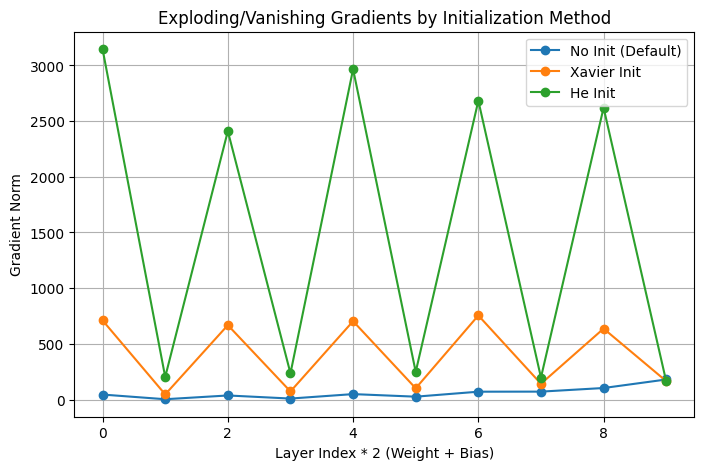

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Parameters
input_size = 1000
hidden_size = 256
layers = 5
batch_size = 16

# Simple feedforward network factory
def make_network(init_type=None):
    layers_list = []
    for i in range(layers):
        lin = nn.Linear(input_size if i==0 else hidden_size, hidden_size)
        # Apply initialization
        if init_type == 'xavier':
            nn.init.xavier_uniform_(lin.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(lin.weight, nonlinearity='relu')
        # No init means PyTorch default
        layers_list.append(lin)
        layers_list.append(nn.ReLU())
    return nn.Sequential(*layers_list)

# Generate random input
x = torch.randn(batch_size, input_size)

# Track gradient norms
def compute_grad_norms(init_type=None):
    model = make_network(init_type)
    x.requires_grad = True
    out = model(x)
    loss = out.sum()
    loss.backward()
    norms = [p.grad.norm().item() for p in model.parameters() if p.grad is not None]
    return norms

# Compute for each initialization
no_init_norms = compute_grad_norms(None)
xavier_norms = compute_grad_norms('xavier')
he_norms = compute_grad_norms('he')

# Plot
plt.figure(figsize=(8,5))
plt.plot(no_init_norms, label='No Init (Default)', marker='o')
plt.plot(xavier_norms, label='Xavier Init', marker='o')
plt.plot(he_norms, label='He Init', marker='o')
plt.xlabel("Layer Index * 2 (Weight + Bias)")
plt.ylabel("Gradient Norm")
plt.title("Exploding/Vanishing Gradients by Initialization Method")
plt.legend()
plt.grid(True)
plt.show()


# Lesson 7: Batch Normalization & Layer Normalization

In [16]:
# the batch norm is for normalizing the batches that goes thro the layers why it is good it makes the data flow managed and normalized better for the nns to learn

# the layers norm is for normalizing the weights from the forward into new sequence of weights that are managed that can make the layers have better output its usally used in transformers nx forms to make the sequneces knowledge more scaled and managed

# the batch norm is on the data
# the layer norm is on layers

# Why Use Normalization?

# Prevents activations from drifting into saturated regions (e.g., sigmoid/tanh where gradients vanish).

# Enables higher learning rates and faster convergence.

# Provides slight regularization (reduces overfitting).

# BN: Good for CNNs, large batch sizes.

# LN: Better for RNNs, Transformers, or when batch size is small.


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np


class ModelBN(nn.Module):
  def __init__(self):
    super(ModelBN,self).__init__()
    self.fc1 = nn.Linear(100,50)
    self.bn1 = nn.BatchNorm1d(50)
    self.fc2 = nn.Linear(50,10)
    self.bn2 = nn.BatchNorm1d(10)
    self.fc3 = nn.Linear(10,2)


    for layer in [self.fc1,self.fc2]:
      torch.nn.init.kaiming_uniform_(layer.weight,nonlinearity='relu')
      torch.nn.init.constant_(layer.bias,0.01)

  def forward(self,x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

df = {
    "p":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    "v":[10,20,30,40,50,60,70,80,90,100],
    "a":[1,0,1,0,1,0,1,0,1,0]
}

df = pd.DataFrame(df)

arrx = np.array(df["p"])
arrx2 = np.array(df["v"])
arry = np.array(df["a"])

x = [arrx,arrx2]
x = torch.tensor(x)

y = torch.tensor(arry)

print(f"val : {x} , target ---> {y}")


model = ModelBN()





val : tensor([[  0.1000,   0.2000,   0.3000,   0.4000,   0.5000,   0.6000,   0.7000,
           0.8000,   0.9000,   1.0000],
        [ 10.0000,  20.0000,  30.0000,  40.0000,  50.0000,  60.0000,  70.0000,
          80.0000,  90.0000, 100.0000]], dtype=torch.float64) , target ---> tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


Using: cuda


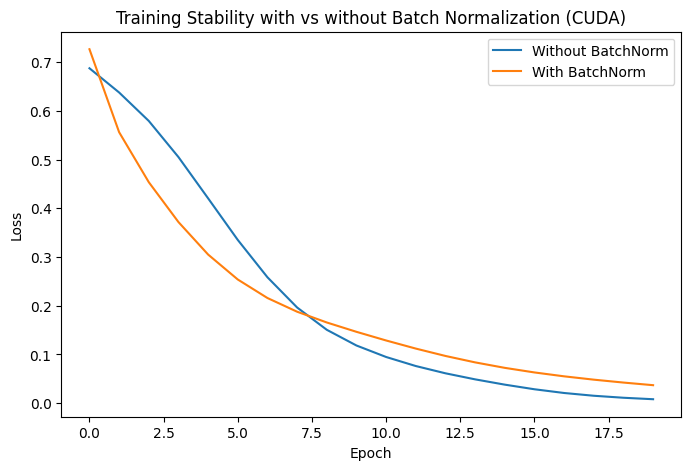

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Synthetic dataset
X = torch.randn(1000, 20).to(device)
y = (torch.sum(X, dim=1) > 0).float().to(device)

# Simple model builder
def build_model(use_bn=False):
    layers = []
    layers.append(nn.Linear(20, 64))
    if use_bn: layers.append(nn.BatchNorm1d(64))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(64, 64))
    if use_bn: layers.append(nn.BatchNorm1d(64))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(64, 1))
    return nn.Sequential(*layers).to(device)

# Training loop
def train(model, epochs=20, lr=0.01):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(X).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# Compare models
model_no_bn = build_model(use_bn=False)
model_bn = build_model(use_bn=True)

loss_no_bn = train(model_no_bn)
loss_bn = train(model_bn)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(loss_no_bn, label="Without BatchNorm")
plt.plot(loss_bn, label="With BatchNorm")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Stability with vs without Batch Normalization (CUDA)")
plt.legend()
plt.show()


# Lesson 8: Dropout & Regularization ,Gradient Descent Variants

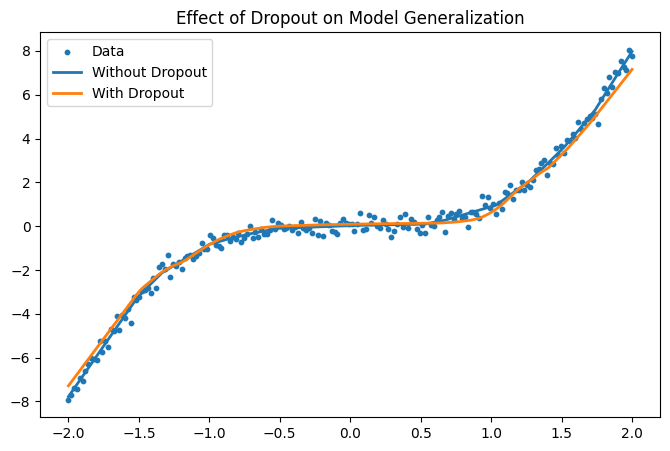

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy dataset
X = torch.linspace(-2, 2, 200).view(-1, 1).to(device)
y = X.pow(3) + 0.3 * torch.randn(X.size()).to(device)

# Model with Dropout
class NetWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout applied
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Model without Dropout
class NetWithoutDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# Train function
def train(model, epochs=500):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    return model

# Train both models
model_no_drop = train(NetWithoutDropout().to(device))
model_drop = train(NetWithDropout().to(device))

# Plot predictions
model_no_drop.eval()
model_drop.eval()
X_test = torch.linspace(-2, 2, 200).view(-1, 1).to(device)
with torch.no_grad():
    y_pred_no_drop = model_no_drop(X_test).cpu()
    y_pred_drop = model_drop(X_test).cpu()

plt.figure(figsize=(8, 5))
plt.scatter(X.cpu(), y.cpu(), s=10, label="Data")
plt.plot(X_test.cpu(), y_pred_no_drop, label="Without Dropout", linewidth=2)
plt.plot(X_test.cpu(), y_pred_drop, label="With Dropout", linewidth=2)
plt.legend()
plt.title("Effect of Dropout on Model Generalization")
plt.show()


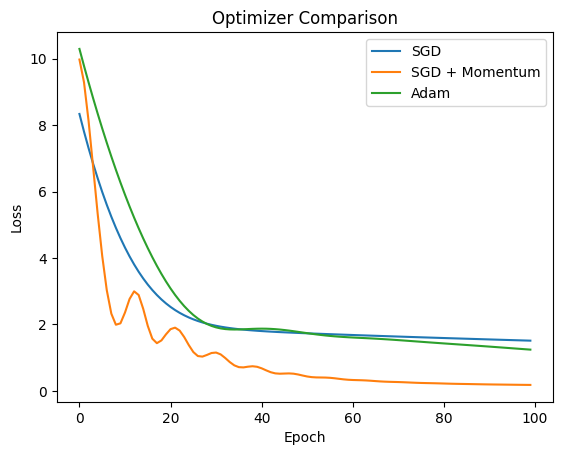

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dummy dataset
X = torch.unsqueeze(torch.linspace(-2, 2, 200), dim=1).to(device)
y = X.pow(3) + 0.3 * torch.randn(X.size()).to(device)

# Simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(1, 20)
        self.out = nn.Linear(20, 1)
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.out(x)

# Training function
def train_model(optimizer_name):
    net = Net().to(device)
    criterion = nn.MSELoss()
    optimizer = {
        'SGD': optim.SGD(net.parameters(), lr=0.01),
        'Momentum': optim.SGD(net.parameters(), lr=0.01, momentum=0.9),
        'Adam': optim.Adam(net.parameters(), lr=0.01)
    }[optimizer_name]

    losses = []
    for epoch in range(100):
        pred = net(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

# Compare optimizers
loss_sgd = train_model('SGD')
loss_mom = train_model('Momentum')
loss_adam = train_model('Adam')

plt.plot(loss_sgd, label='SGD')
plt.plot(loss_mom, label='SGD + Momentum')
plt.plot(loss_adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimizer Comparison')
plt.legend()
plt.show()


# Lesson on torch.utils.data (Data Loading & Management)

if we use x = np
or fast approaches
this means torch.utils.data.TensorDataset – wraps tensors directly (simple use cases).

In [15]:
#Example: TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader

x  = torch.randn(1000,3)
y = torch.randint(0,2,(1000,))

ds = TensorDataset(x,y)

loader = DataLoader(ds,batch_size=100,shuffle=True)

for batch_x,batch_y in loader:
  print(batch_x,batch_y)
  break

tensor([[-1.2831e+00, -1.0966e-01, -1.1603e-01],
        [-2.5389e+00, -1.0761e+00, -4.4405e-01],
        [-1.0069e+00, -2.2716e-01, -8.9701e-01],
        [-4.0428e-01, -1.0888e+00,  9.1621e-01],
        [-3.1986e-01, -7.2851e-01, -4.8847e-01],
        [ 2.9935e-01, -9.6815e-01,  9.4508e-01],
        [-2.0417e+00,  1.3110e-01, -7.4112e-01],
        [ 9.0742e-01, -2.0148e+00,  1.6243e+00],
        [ 4.6034e-02, -3.8703e-01, -9.2919e-01],
        [ 4.0827e-01, -4.8352e-02,  7.6799e-01],
        [ 6.7365e-01,  2.9224e-01, -5.9128e-01],
        [ 1.8267e+00, -9.7868e-01,  2.5225e-02],
        [-4.6637e-01,  1.5751e-01, -1.7370e-01],
        [ 8.2497e-01,  2.6165e-01,  1.0425e+00],
        [-9.0225e-01, -4.5363e-01,  2.4164e-02],
        [-2.4909e-01, -2.2370e-02, -3.3167e-01],
        [ 3.6444e-01, -6.1390e-01, -1.3887e+00],
        [-3.0175e-01,  9.5858e-01,  6.7262e-01],
        [ 8.3849e-01, -1.6090e+00,  2.6486e+00],
        [-5.9507e-03,  1.4805e+00, -1.5538e-01],
        [ 1.4445e+00

the custom data set when you use pd and csvs etc

In [16]:
from torch.utils.data import Dataset as ds
import pandas as pd

class DS(ds):
  def __init__(self,csv_path):
    self.data = pd.read_csv(csv_path)

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    feat = torch.tensor(self.data.iloc[idx,:-1].values, dtype=torch.float32)
    label = torch.tensor(self.data.iloc[idx,-1], dtype=torch.long)
    return feat, label

Using device: cuda
TensorDataset Batch: X shape=torch.Size([32, 10]), y shape=torch.Size([32])
CustomDataset Batch: X shape=torch.Size([32, 10]), y shape=torch.Size([32])


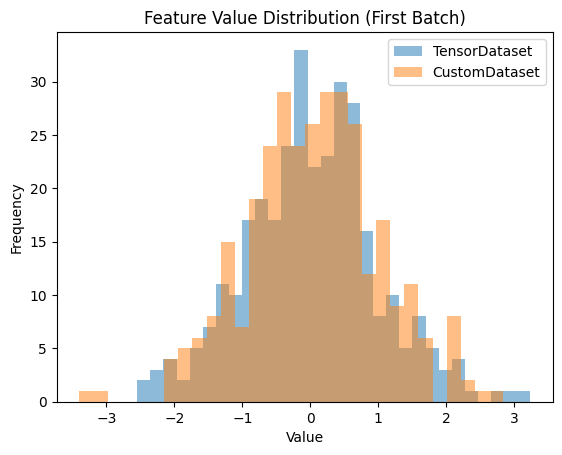

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Check CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- 1. Using TensorDataset -----
# Create random data (features & labels)
X = torch.randn(500, 10)
y = torch.randint(0, 2, (500,))

# Create TensorDataset
tensor_dataset = TensorDataset(X, y)
tensor_loader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

# ----- 2. Using Custom Dataset -----
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return feature and label as tensors
        return self.X[idx], self.y[idx]

custom_dataset = CustomDataset(X, y)
custom_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# ----- 3. Move a batch to CUDA -----
def get_batch(loader):
    for batch_X, batch_y in loader:
        return batch_X.to(device), batch_y.to(device)

tensor_X, tensor_y = get_batch(tensor_loader)
custom_X, custom_y = get_batch(custom_loader)

print(f"TensorDataset Batch: X shape={tensor_X.shape}, y shape={tensor_y.shape}")
print(f"CustomDataset Batch: X shape={custom_X.shape}, y shape={custom_y.shape}")

# ----- 4. Visualize batch distribution -----
plt.hist(tensor_X.cpu().numpy().flatten(), bins=30, alpha=0.5, label="TensorDataset")
plt.hist(custom_X.cpu().numpy().flatten(), bins=30, alpha=0.5, label="CustomDataset")
plt.title("Feature Value Distribution (First Batch)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# the diffrence between archt in regression nns and cls nns

1. Output Layer

Regression:

Output layer usually has 1 neuron (for single-output regression) or n neurons (for multi-output regression).

Activation function is often none or linear (identity) so that predictions can take any real value (e.g., y ∈ ℝ).

Classification:

Output layer has:

1 neuron with sigmoid for binary classification (outputs probability 0–1).

n neurons with softmax for multi-class classification (outputs class probabilities summing to 1).

2. Activation Functions

Regression:

Hidden layers: ReLU, Tanh, LeakyReLU, etc.

Output layer: No activation (linear output).

Classification:

Hidden layers: Same as regression (ReLU, etc.).

Output layer:

Binary: Sigmoid.

Multi-class: Softmax.

3. Loss Functions

Regression:

Mean Squared Error (MSE)

Mean Absolute Error (MAE)

Huber Loss (for robustness to outliers)

Classification:

Binary Cross-Entropy (BCE) for binary classification.

Cross-Entropy Loss (CE) for multi-class classification.